In [22]:
from copy import deepcopy
from datetime import date, datetime, timedelta
from functools import partial
from importlib import reload
from pathlib import Path

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import tensorflow as tf
from datapoints import assets
from plotly.subplots import make_subplots
from query_datasets import get_data
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import estimator_checks
from tensorflow.keras import layers
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.models import Model
from tools import dataframe, plotting, training, wandb_api
from tqdm import tqdm
from wandb.keras import WandbCallback

log_wandb = False
pio.renderers.default = "browser"


In [7]:
if log_wandb:
    import wandb

    wandb_api.login()
    run = wandb.init(
        project="crypto_prediction",
        group="Adaboost LSTM",
        job_type="test",
    )
    config = wandb.config

else:
    config = {}

config["job_type"] = run.job_type if "run" in locals() else "test"
config["train_val_test_split"] = [0.66, 1-0.66, 0]
config["interval"] = "1d"
config["timesteps"] = 8
config["lag"] = 1
config["ago"] = 3000
config["batch_size"] = 64
config["learning_rate"] = 0.0003

In [8]:
interesting_tickers = [
    # "XRP",
    # "EOS",
    # "NEO",
    # "ALGO",
    # "SNX",
    # "ETH",
    # "AAVE",
    # "BNB",
    "BTC",
    # "DOT",
    # "XTZ",
    # "TRX",
    # "ADA",
    # "MATIC",
    # "DOGE",
    # "KLAY",
    # "AVAX",
    # "GRT",
    # "SAND",
    # "SOL",
    # "MANA",
    # "ATOM",
    # "VET",
    # "OMG",
]


In [61]:
def compute_features(data, timesteps=8, lag=5):
    features = data.copy(deep=True)

    for i in range(timesteps):
        for col in data.columns:
            features[f"{col}_{i}"] = features[col].pct_change().shift(i)
            # features[f"open_{i}"] = features.loc[:, "Open"].shift(i)
            # features[f"high_{i}"] = features.loc[:, "High"].shift(i).pct_change()
            # features[f"low_{i}"] = features.loc[:, "Low"].shift(i).pct_change()
            # features[f"close_{i}"] = features.loc[:, "Close"].shift(i).pct_change()
            # features[f"volume_{i}"] = features.loc[:, "Volume"].shift(i).pct_change()

    labels = features["Close"].pct_change().shift(-lag)  # - features["Open"].shift(-1)
    features = features.drop(labels=data.columns, axis=1)

    scaler = MinMaxScaler()
    features = features.replace(
        to_replace=[np.inf, -np.inf, float("inf"), float("inf")],
        value=0,
    ).dropna()
    df_scaled = features #scaler.fit_transform(features)
    df_scaled = pd.DataFrame(df_scaled, columns=features.columns, index=features.index)
    return df_scaled, labels


def create_asset(
    ticker,
    interval,
    beginning_date,
    ending_date,
    compute_features=lambda x: x,
):

    klines = get_data.download_klines(
        ticker,
        interval,
        beginning_date=beginning_date,
        ending_date=ending_date,
        directory=Path().resolve().parent / "ada_lstm" / "tmp",
    )
    trends = get_data.download_trends(
        ticker,
        interval,
        beginning_date=beginning_date,
        ending_date=ending_date,
        directory=Path().resolve().parent / "ada_lstm" / "tmp",
    )
    blockchain_infos = get_data.download_blockchain(
        "BTC",
        interval,
        beginning_date=beginning_date,
        ending_date=ending_date,
        directory=Path().resolve().parent / "ada_lstm" / "tmp",
    )
    santiment = get_data.download_santiment(
        "BTC",
        interval,
        beginning_date=beginning_date,
        ending_date=ending_date,
        directory=Path().resolve().parent / "ada_lstm" / "tmp",
    )
    data = pd.concat([klines, blockchain_infos, trends, santiment], axis=1).astype(
        "float32"
    )
    data = data.replace(
        to_replace=[np.inf, -np.inf, float("inf"), float("inf")],
        value=0,
    )

    features, labels = compute_features(data)

    return assets.TrainAsset(
        ticker=ticker,
        df=data,
        labels=labels,
        features=features,
        interval=interval,
        compute_features=compute_features,
    )


class DataModule:
    def __init__(
        self,
        config,
        compute_features=None,
        inputs=None,
        save_klines=True,
    ):
        self.config = config
        self.compute_features = compute_features
        self.inputs = inputs
        self.save_klines = save_klines

        self.setup()

    def setup(self):
        self.train_datapoints = []
        for input in self.inputs:
            dp = create_asset(
                **input,
                interval=self.config["interval"],
                compute_features=self.compute_features,
            )
            if dp == []:
                continue
            dp.df = dp.df.dropna()
            dp.labels = dp.labels.dropna()
            dp._features = dp._features.dropna()

            common_index = dp.df.index.intersection(dp.labels.index)
            common_index = common_index.intersection(dp._features.index)

            dp.df = dp.df.loc[common_index]
            dp.labels = dp.labels.loc[common_index]
            dp._features = dp._features.loc[common_index]

            train_dp = assets.TrainAsset(
                ticker=input["ticker"],
                df=dp.df,
                labels=dp.labels,
                features=dp._features,
                interval=self.config["interval"],
                compute_features=self.compute_features,
            )
            if not train_dp.isempty:
                self.train_datapoints.append(train_dp)
            else:
                print(
                    f"{dp.ticker} is empty from {input['beginning_date']} to {input['ending_date']}."
                )

    def clean_datapoints(self, datapoints):
        return datapoints

    def concat_and_shuffle(self, features, labels):
        assert len(features) == len(labels)
        _features = np.concatenate(features, axis=0)
        _labels = np.concatenate(labels, axis=0)
        assert len(_features) == len(_labels)
        p = np.random.permutation(len(_features))
        return _features[p], _labels[p]

    def nest_train_test_val_split(
        self, datapoints, offset, train_size, val_size, test_size=0
    ):
        train_features = []
        train_labels = []
        val_features = []
        val_labels = []
        test_datapoints = {}
        for dp in datapoints:
            train_beginning = offset
            train_ending = train_beginning + train_size
            val_beginning = train_ending
            val_ending = val_beginning + val_size

            test_beginning = val_beginning
            test_ending = val_ending
            # test_beginning = val_ending
            # test_ending = test_beginning + test_size

            train_features.append(dp._features[train_beginning:train_ending])
            train_labels.append(dp.labels[train_beginning:train_ending])
            val_features.append(dp._features[val_beginning:val_ending])
            val_labels.append(dp.labels[val_beginning:val_ending])

            test_datapoints[dp.ticker] = assets.TrainAsset(
                ticker=dp.ticker,
                df=dp.df.iloc[test_beginning:test_ending],
                labels=dp.labels.iloc[test_beginning:test_ending],
                features=dp._features.iloc[test_beginning:test_ending],
                interval=dp.interval,
                compute_features=dp.compute_features,
            )

        return (
            self.concat_and_shuffle(train_features, train_labels),
            self.concat_and_shuffle(val_features, val_labels),
            test_datapoints,
        )

    def _init_train_val_data(self, train_datapoints):
        train_datapoints = self.clean_datapoints(train_datapoints)
        if self.config["train_val_test_split"][0] > 1:
            train_size = int(self.config["train_val_test_split"][0])
        else:
            train_size = int(
                len(train_datapoints[0].df) * self.config["train_val_test_split"][0]
            )
        if self.config["train_val_test_split"][1] > 1:
            val_size = int(self.config["train_val_test_split"][1])
        else:
            val_size = int(
                len(train_datapoints[0].df) * self.config["train_val_test_split"][1]
            )
        if self.config["train_val_test_split"][2] > 1:
            test_size = int(self.config["train_val_test_split"][2])
        else:
            test_size = int(
                len(train_datapoints[0].df) * self.config["train_val_test_split"][2]
            )
        print(f"train_size: {train_size}, val_size: {val_size}, test_size: {test_size}")
        max_offset = max(
            len(train_datapoints[0].df) - (train_size + val_size + test_size), 1
        )
        train_datasets = []
        val_datasets = []
        test_datapoints = []
        for offset in range(0, max_offset, val_size + test_size):
            train_dataset, val_dataset, test_datapoint = self.nest_train_test_val_split(
                train_datapoints, offset, train_size, val_size, test_size
            )
            train_datasets.append(train_dataset)
            val_datasets.append(val_dataset)
            test_datapoints.append(test_datapoint)
        return train_datasets, val_datasets, test_datapoints


config["job_type"] = run.job_type if "run" in locals() else "test"
config["train_val_test_split"] = [0, 3000, 0]
config["interval"] = "1d"
config["timesteps"] = 2
config["lag"] = 1
config["ago"] = 3000
config["batch_size"] = 64
config["learning_rate"] = 0.0003

inputs = [
    {
        "ticker": ticker,
        "beginning_date": datetime.combine(date.today(), datetime.min.time())
        - dataframe.convert_to_timedelta(config["interval"], ago=config["ago"]),
        "ending_date": datetime(
            2022, 5, 21
        ),  # datetime.combine(date.today(), datetime.min.time()),
    }
    for ticker in interesting_tickers
]

dm = DataModule(
    config,
    partial(compute_features, timesteps=config["timesteps"], lag=config["lag"]),
    inputs,
    save_klines=True,
)
train_datasets, val_datasets, test_datapoints = dm._init_train_val_data(
    dm.train_datapoints
)
print(f"Length training dataset: {len(train_datasets)}")
print(f"Length validation dataset: {len(train_datasets)}")
print(f"Length test dataset: {len(train_datasets)}")

print(f"Shape training sample: {train_datasets[0][0].shape}")
print(f"Shape training sample: {train_datasets[0][0].shape[1] / config['timesteps']}")

print(f"Shape validation sample: {val_datasets[0][0].shape}")
config["input_size"] = train_datasets[0][0].shape[1]
assert (
    config["input_size"] // config["timesteps"]
    == config["input_size"] / config["timesteps"]
)


train_size: 0, val_size: 3000, test_size: 0
Length training dataset: 1
Length validation dataset: 1
Length test dataset: 1
Shape training sample: (0, 38)
Shape training sample: 19.0
Shape validation sample: (2074, 38)


In [62]:
df.loc[:, ["Volume_0", "Volume_1"]]

,Volume_0,Volume_1
Datetime,,
2016-07-02 00:00:00+00:00,0.000223,0.000286
2016-07-03 00:00:00+00:00,0.000272,0.000223
2016-07-04 00:00:00+00:00,0.000165,0.000272
2016-07-05 00:00:00+00:00,0.000275,0.000165
2016-07-06 00:00:00+00:00,0.000288,0.000275
...,...,...
2022-05-15 00:00:00+00:00,0.073522,0.081343
2022-05-16 00:00:00+00:00,0.092838,0.073522
2022-05-17 00:00:00+00:00,0.082829,0.092838


In [63]:
import plotly.io as pio
import plotly.express as px

df = test_datapoints[0]["BTC"]._features
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
df_mask = corr.mask(mask)


fig = go.Figure(
    go.Heatmap(
        z=corr.mask(mask),
        x=corr.columns,
        y=corr.columns,
        colorscale=px.colors.diverging.RdBu,
        zmin=-1,
        zmax=1,
    )
)
fig.update_layout(
    height=1000,)
fig.show()

In [67]:
fig = go.Figure(go.Scatter(x=df.iloc[-last_n_days:, :].index, y=df.iloc[-last_n_days:, :]["Open_0"]))
fig.show()

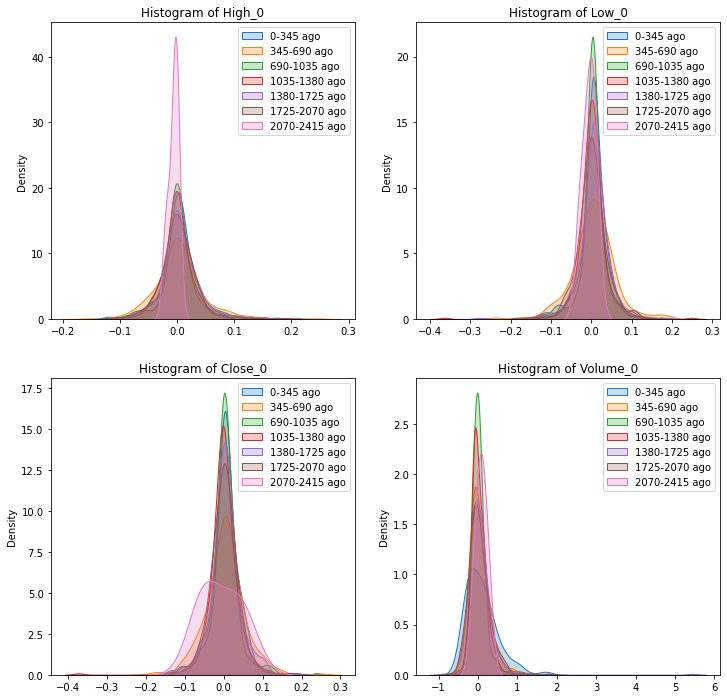

In [66]:
dataframes = []
labels = []
interval = len(df) // 6
for i in range(0, len(df), interval):
    a = df.iloc[i:i+interval, 1:5]
    if not a.empty:
        dataframes.append(a)
        labels.append(f"{i}-{i+interval} ago")

fig, axs = plotting.plot_kde(dataframes, 2, labels=labels)